In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [3]:
N      = 500
B      = 20
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1

In [4]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [5]:
DOES_NOT_MATTER = MSAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=0.001,
        δmin=δmin,
        εmin=200.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=100)) #### notice maxiter=1
PARTICLES = DOES_NOT_MATTER.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 95776101215.8371887207031250
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 40480.7754063356405823
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9460000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 904.7420540176740360
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 89.7270701049275914
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9440000000000000
	Step-size kept fixed at: 0.0010000000000000


# Create a grid of values for $\delta$ and for $B$

In [6]:
Bs = np.arange(start=10, stop=31, step=1, dtype=int)
δs = np.array([1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.0001])

# Test Run

In [27]:
def run_ms(δδδ, BBB):
    something = MSAdaptive(generate_settings(d=d, N=100, B=int(BBB),
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=False, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=DOES_NOT_MATTER.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
    something.sample()
    return np.mean(something.ESS_SMC[-1])

In [28]:
ess_smc_values = np.zeros((len(δs), len(Bs)))
for δix, δδδ in enumerate(δs):
    for Bix, BBB in enumerate(Bs):
        ess_smc_values[δix, Bix] = run_ms(δδδ, BBB)

In [ ]:
ess_smc_values2 = np.zeros((len(δs), len(Bs)))
for δix, δδδ in enumerate(δs):
    for Bix, BBB in enumerate(Bs):
        ess_smc_values2[δix, Bix] = run_ms(δδδ, BBB)

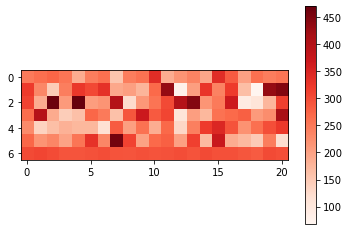

In [40]:
fig, ax = plt.subplots()
out = ax.imshow(ess_smc_values, cmap='Reds')
fig.colorbar(out)
plt.show()

In [42]:
NNN = 5000

In [44]:
DOES_NOT_MATTER_NEW = MSAdaptive(generate_settings(
        d=d, 
        N=NNN,
        B=B,
        δ=0.001,
        δmin=δmin,
        εmin=200.0,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial',
        maxiter=100)) #### notice maxiter=1
PARTICLES_NEW = DOES_NOT_MATTER_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9452000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 565.3519731500406351
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9518000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 102.2527143830564853
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9562000000000000
	Step-size kept fixed at: 0.0010000000000000


In [46]:
BAZ13 = MSAdaptive(generate_settings(d=d, N=NNN, B=B,
        δ=0.01, δmin=δmin, min_pm=min_pm, verbose=False, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES_NEW, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=DOES_NOT_MATTER_NEW.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = BAZ13.sample()

In [48]:
SOME = SMCAdaptive(generate_settings(d=d, N=NNN, B=B,
        δ=0.01, δmin=δmin, min_pm=min_pm, verbose=False, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES_NEW, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=DOES_NOT_MATTER_NEW.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = SOME.sample()

Let's compare the SMC with the underlying SMC in the MS

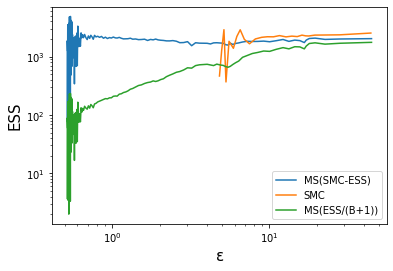

In [59]:
fig, ax = plt.subplots()
ax.plot(BAZ13.εs[1:], BAZ13.ESS_SMC[1:], label='MS(SMC-ESS)')
ax.plot(SOME.εs[1:], SOME.ESS[1:], label='SMC')
ax.plot(BAZ13.εs[1:], np.array(BAZ13.ESS[1:]) / (B+1), label='MS(ESS/(B+1))')
ax.set_xscale('log')
ax.set_xlabel(r"$\mathregular{\varepsilon}$", fontsize=15)
ax.set_ylabel("ESS", fontsize=15)
ax.set_yscale('log')
plt.legend()
plt.savefig("figures/gk20_msess_msesssmc_smcess.png")
plt.show()

# Robustness with respect to $B$

The performance of the algorithm depends on two parameters:

1. $B$ the total number of steps
2. $\delta$ the step size

Together these define the integration time $T = B \delta$. Having two tuneable parameters is not great, hence we would like to either find a heuristic for setting them, or show that Markov Snippets are more robust than SMC to one or both choices of parameters. 

> We know that for fixed $B$, Markov Snippets are more robust to the choice of $\delta$ than SMC. Indeed they are able to run with larger step sizes and achieve small $\epsilon$s. 

Let's turn to the choice of $B$, which fully determines $T$. Clearly, if one had the computational resources, one could set $B$ to be very large. If $B$ is too large, it doesn't matter, we will simply waste computation, but we will still explore the space well, in fact, very well, if $\delta$ is chosen small enough but not too small. In practice we will have a computational budget. In our algorithm the computational cost is:
$$
C_{\text{MS}} = P \times N \times B \times C_\psi
$$
where 
- $P$ is the number of iterations of the algorithm before it stops.
- $N$ is the number of particles
- $B$ is the number of integration steps 
- $C_\psi$ is the cost of running the integrator for one step

The number of iterations before the algorithm stops depend, among other things, on $B$, $\delta$ and $N$ for sure.
$$
P = P(N, B, \delta)
$$
Suppose for parallelization reasons that $N$ is fixed. Then given a computational budget of $\mathcal{B}$ we want to distribute this well enough. if $B$ changes throughout each iteration, then the total cost will be 
$$
C_{MS} = \sum_{p=0}^{P(N, B_0, \delta)} N B_p C_\psi
$$

> FORGET ABOUT COMPUTATIONAL TIME NOW. USE FEW PARTICLES. IF I GIVE IT VERY LARGE INTEGRATION TIME, DOES IT GO TO SMALL EPSILON FASTER?
- start from prior
- run with few particles
- run with small enough step size
- run with VERY large $B$ and see what happens
- compare this with the same except smaller $B$

Notice that for $B$ large we need to remove the stopping criterion `pm` as of course we will have a very small proportion of moved particles when we reach small epsilons. It is expected and, in this case, wanted. For fairness we remove this stopping criterion also for the MS with smaller $B$.

In [135]:
NNN = 5000
δδδ = 0.01

Actually, since the very beginning is always somewhat fast, let's try initializing at a small/large enough epsilon. I also need more particles to make sure the results are somewhat "average".

##### Generate Particles

In [120]:
θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
ystar     = data_generator(θ0, m, seed=seed)  # Observed data
q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
resetwarnings()
manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

def generate_initial_points(ε=200, δ=0.4, N=5000, mult=10):
    # Generate target distribution
    logηε = manifold.generate_logηε(ε=200)
    # Find initial point
    x0 = manifold.sample(advanced=True, fromtheta=True)
    # Sample starting from x0
    samples, acceptances = RWM(x0, s=δ, N=N*mult, logpi=logηε)
    print("AP: {:.3f}".format(np.mean(acceptances)*100))
    return samples[::mult]

X_PARTICLES = generate_initial_points(ε)
V_PARTICLES = np.random.randn(*X_PARTICLES.shape)
PARTICLES   = np.hstack((X_PARTICLES, V_PARTICLES))

AP: 25.430


##### Run Markov Snippets for increasing $B$

In [136]:
# B=10
MS10 = MSAdaptive(generate_settings(d=d, N=NNN, B=10,
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS10.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 57.2076100834640400
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9098000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.4384092117355820
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9064000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.1794883477752869
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9122000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 20.3458670153855259
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	P

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2788000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5362627461305620
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2718000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5092329683602086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2502000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4813003819870373
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2220000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4554227022427212
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1550000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1946940539258748
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0062000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1896954139803407
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0014000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1857515263546086
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0024000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1792098186724637
	Wei

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_39406/3912492277.py:336: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


In [138]:
# B=25
MS25 = MSAdaptive(generate_settings(d=d, N=NNN, B=25,
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS25.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 57.2076100834640400
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9606000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 34.0998993301701461
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9582000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.2315855922140102
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9614000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 20.4884841279728391
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	P

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5150000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9900413977495128
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4842000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9383266963755957
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4506000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8907220087045091
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4186000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8472553584877538
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0194000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2212451611218048
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0066000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2143174564799750
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0070000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2099033397189910
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2052933246723700
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0008000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1182492841874800
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1132190961094082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1098651215490120
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1095471693207905


	Epsilon: 0.0794491491297923
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0768508713636443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0768508713636443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0768508713636443
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  137
	Quantile Value:  0.5
	Trajectories constructed.


	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  170
	Quantile Value:  0.5
	Trajectories constructed.


	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0753399017044762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.


	Trajectories constructed.
	Epsilon: 0.0737986597805931
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0737986597805931
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0737986597805931
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  235
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0737986597805931
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  236
	Quantile Value:  0.5


In [140]:
# B=50
MS50 = MSAdaptive(generate_settings(d=d, N=NNN, B=50,
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS50.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 57.2076100834640400
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9816000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 35.2197126701699617
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9836000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.8549237304478474
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9762000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 21.5441968397600583
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	P

	Epsilon: 2.0928621578901918
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7402000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9846229806495699
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7240000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8816297393171240
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7280000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7784155096704082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7030000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Eps

	Epsilon: 0.5707411805336861
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2216000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5549727551856501
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2090000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5413397955777181
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2030000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5275101494875625
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1824000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Eps

	Epsilon: 0.3294928654569355
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0082000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3261346150275602
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0056000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3237105683749019
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2896000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3209816684082787
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0056000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.


	Trajectories constructed.
	Epsilon: 0.2619889919850287
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2582259063308467
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0016000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2556692083361672
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2553489955040223
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  137
	Quantile Value:  0.5


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_39406/3912492277.py:336: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


##### From the prior..

Add back `pm` into the stopping criteria. Set it to `1/NNN`

In [252]:
# B=10
MS_PRIOR_SHORT_NEW = MSAdaptive(generate_settings(d=d, N=NNN, B=10,
        δ=δδδ, δmin=δmin, min_pm=(1/NNN), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS_PRIOR_SHORT_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7706000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 502.0065584788795832
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9122000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 86.4652648441119140
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9018000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 40.1257727281778074
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8504000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.0383787272070721
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8426000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.7812579580225680
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8466000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5360810568133427
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8370000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.3115976325829015
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5208000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2036783465187515
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5152000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1665506314169760
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5196000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1289313506751055
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5016000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0965969538819227
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1328000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6652417276193883
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1132000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6603875908712715
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1274000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6563704911276638
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1258000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6519652282481767


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0862000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5533590299878750
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1088000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5500599699016369
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0582000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5473650806893107
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0438000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5451168556030170


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0020000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5033864828019292
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0266000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5032150131040567
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0012000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5028639904342271
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0002000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5024713663933880


In [260]:
# B=50
MS_PRIOR_LONG_NEW = MSAdaptive(generate_settings(d=d, N=NNN, B=50,
        δ=δδδ, δmin=δmin, min_pm=(1/NNN), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS_PRIOR_LONG_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8020000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 464.2481425461155595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9784000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 84.3987497398842663
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9788000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 42.7782399636630970
	Weights 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8330000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3135849811771227
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8190000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1893534777303261
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8118000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0741136542860179
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8144000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9535274447242403
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5476000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2933948295204418
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2625053815867049
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4934000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2379592557126169
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4668000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2158666844495540
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2256000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5814394764659950
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2014000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5658443271214332
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2218000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5492703759116435
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1936000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5353581892709837


In [181]:
# # B=10
# MS_PRIOR_SHORT = MSAdaptive(generate_settings(d=d, N=NNN, B=10,
#         δ=δδδ, δmin=δmin, min_pm=(1/NNN), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
#         z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
#         εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
#         switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
#         resampling_scheme='multinomial', maxiter=500))
# _ = MS_PRIOR_SHORT.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7706000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 502.0065584788795832
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9112000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 87.8690674068080853
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9110000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 39.5743544735785449
	Weights com

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8418000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6596098783199702
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8128000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.4623873783340979
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8090000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.2854689870825213
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7912000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.1278831316237348
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5028000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9725592904426796
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4930000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9510335429559464
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4552000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9303684748656129
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4312000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9120145081643840
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2504000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5995389608767818
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2416000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5910759742991325
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2648000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5812703820243130
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2970000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5710862650376352


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0614000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4112240790449309
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0976000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4080425422066809
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1030000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4041665671799048
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1212000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4005810902051776


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2662000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2831189458221068
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2920000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2705250738541196
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3514000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2529077693430912
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3742000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2297869650738422


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0564000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4033021568088722
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0716000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3952917089913882
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0752000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3872154640539035
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0364000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3801853462738816


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1576000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2569264635241590
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0032000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2537860895714641
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0034000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2518649921697816
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0026000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  235
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2497938803664076


	Epsilon: 0.1890160981054002
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1865369950856615
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0022000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1851392396878650
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1734866041832082
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  268
	Quantile Value:  0.5
	Trajectories constructed.


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_39406/3912492277.py:336: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


In [195]:
# B=20
MS_PRIOR_MEDIUM = MSAdaptive(generate_settings(d=d, N=NNN, B=20,
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS_PRIOR_MEDIUM.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7926000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 508.0577595705839826
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9518000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 86.1710734864323911
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9530000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 39.8631220164215705
	Weights com

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7492000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4262762361729582
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7378000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2934438303728140
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7171999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1697563279570971
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7042000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0612606389042818
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2316000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8526511156327032
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2288000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8380921663940220
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2114000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8234505087005153
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2212000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8101421467573282
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0174000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6664943233627114
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0092000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6645075979519628
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0064000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6626202827937502
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0856000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6612777857902654


	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0006000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6354227853000063
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0018000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6342835875068911
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0994000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6333012236108155
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0024000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6321094597339190


	Epsilon: 1.6151785413825777
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0006000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6148837932548474
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6141851093944344
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6134864255340211
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.


In [182]:
# # B=50
# MS_PRIOR_LONG_NEW = MSAdaptive(generate_settings(d=d, N=NNN, B=50,
#         δ=δδδ, δmin=δmin, min_pm=(1/NNN), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
#         z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
#         εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
#         switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
#         resampling_scheme='multinomial', maxiter=500))
# _ = MS_PRIOR_LONG_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8020000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 464.2481425461155595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9796000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 84.8933915790343718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9830000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 41.1874842172109510
	Weights com

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8224000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7808404649937710
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7896000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6699986719271065
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7877999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.5637659370132377
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7808000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.4660090882386787
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3668000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9162896620176683
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3338000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8950354836577730
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3242000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8766702053248372
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2904000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8586168258111155
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0254000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6337978969920014
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0330000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6318356175066625
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0074000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6285496712820361
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0050000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6260020959026086


	Epsilon: 0.5630071109459318
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0304000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5619216624225345
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0306000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5604404547551504
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0056000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5571424466146502
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0026000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.


	Epsilon: 0.5039468445023760
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0018000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5021881081464314
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1014000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5017328118561746
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0070000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4982535944195879
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0042000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5
	Trajectories constructed.


	Epsilon: 0.3257618924332739
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0896000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3137686097956270
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0304000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3017633954387252
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0380000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2884143267238514
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0200000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_39406/3912492277.py:336: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


In [187]:
# B=100
MS_PRIOR_HUGE = MSAdaptive(generate_settings(d=d, N=NNN, B=100,
        δ=δδδ, δmin=δmin, min_pm=min_pm, verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=None, quantile_value=0.5, initialization='prior',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500))
_ = MS_PRIOR_HUGE.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, 
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22778.8282537224549742
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8002000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 468.5529660887217460
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9890000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 94.1855542652552629
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 40.8237998870001988
	Weights com

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8126000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0181405771083947
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8072000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9035112257854840
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8068000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7939730295093725
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7902000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6871397097263099
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3162000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0342593205770279
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3114000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0064903743409905
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3124000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9822904173675633
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3008000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9584966340191312
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0132000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5875054830241235
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1094000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5817496968390858
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0254000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5743444264607900
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0160000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5691194015540012


	Epsilon: 0.4473951529949803
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4470968956530224
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4470968956530224
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4421464396740857
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5
	Trajectories constructed.


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_39406/3912492277.py:336: RuntimeWarning: invalid value encountered in subtract
  return exp(logw - logsumw)          # normalized weights (N, B+1)


I forgot to put `pm` into the stopping criteria. Hence let's do it post processing. We have $5000$ particles. The variable `PROP_MOVED` is the proportion of the $N$ resampled particles that have been moved forward from the initial particles. We stop algorithms when only one $1/1000$ particles are moved.

In [261]:
THRESH = 5/5000
MAX_IX_SHORT  = np.argmax(np.array(MS_PRIOR_SHORT_NEW.PROP_MOVED)  <= THRESH)
MAX_IX_MEDIUM = np.argmax(np.array(MS_PRIOR_MEDIUM.PROP_MOVED) <= THRESH)
MAX_IX_LONG   = np.argmax(np.array(MS_PRIOR_LONG_NEW.PROP_MOVED)   <= THRESH)
MAX_IX_HUGE   = np.argmax(np.array(MS_PRIOR_HUGE.PROP_MOVED)   <= THRESH)

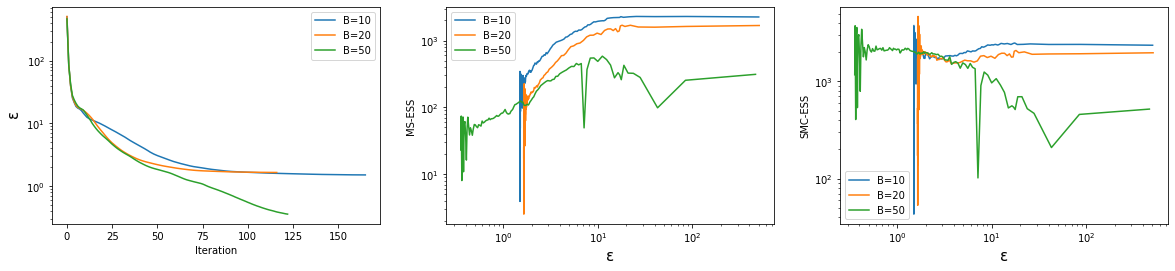

In [291]:
fig, ax = plt.subplots(figsize=(20, 4), ncols=3)
def fESS(ESS, B):
    "Transforms ESS list into np.array and rescaled the values by 1/(B+1)"
    return np.array(ESS) / (B+1)
FROM=2

# Epsilons / Iterations
ax[0].plot(MS_PRIOR_SHORT_NEW.εs[FROM:MAX_IX_SHORT], label="B=10")
ax[0].plot(MS_PRIOR_MEDIUM.εs[FROM:MAX_IX_MEDIUM], label="B=20")
ax[0].plot(MS_PRIOR_LONG_NEW.εs[FROM:MAX_IX_LONG], label="B=50")
# ax[0].plot(MS_PRIOR_HUGE.εs[FROM:MAX_IX_HUGE], label="B=100")
ax[0].set_ylabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[0].set_xlabel("Iteration")
ax[0].set_yscale('log')
ax[0].legend()
# MS-ESS / epsilons
ax[1].plot(MS_PRIOR_SHORT_NEW.εs[FROM:MAX_IX_SHORT], fESS(MS_PRIOR_SHORT_NEW.ESS, 10)[FROM:MAX_IX_SHORT], label="B=10")
ax[1].plot(MS_PRIOR_MEDIUM.εs[FROM:MAX_IX_MEDIUM], fESS(MS_PRIOR_MEDIUM.ESS, 20)[FROM:MAX_IX_MEDIUM], label="B=20")
ax[1].plot(MS_PRIOR_LONG_NEW.εs[FROM:MAX_IX_LONG], fESS(MS_PRIOR_LONG_NEW.ESS, 50)[FROM:MAX_IX_LONG], label="B=50")
# ax[1].plot(MS_PRIOR_HUGE.εs[FROM:MAX_IX_HUGE], fESS(MS_PRIOR_HUGE.ESS, 100)[FROM:MAX_IX_HUGE], label="B=100")
ax[1].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[1].set_ylabel("MS-ESS")
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend()
# SMC-ESS / epsilons
ax[2].plot(MS_PRIOR_SHORT_NEW.εs[FROM:MAX_IX_SHORT], MS_PRIOR_SHORT_NEW.ESS_SMC[FROM:MAX_IX_SHORT], label="B=10")
ax[2].plot(MS_PRIOR_MEDIUM.εs[FROM:MAX_IX_MEDIUM], MS_PRIOR_MEDIUM.ESS_SMC[FROM:MAX_IX_MEDIUM], label="B=20")
ax[2].plot(MS_PRIOR_LONG_NEW.εs[FROM:MAX_IX_LONG], MS_PRIOR_LONG_NEW.ESS_SMC[FROM:MAX_IX_LONG], label="B=50")
# ax[2].plot(MS_PRIOR_HUGE.εs[FROM:MAX_IX_HUGE], MS_PRIOR_HUGE.ESS_SMC[FROM:MAX_IX_HUGE], label="B=100")
ax[2].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[2].set_ylabel("SMC-ESS")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].legend()
# plt.suptitle("Larger B accelerates exploration at the start but stops early", fontsize=15)
plt.savefig("figures/gk20_large_b_accelerates_NEW.png")
plt.show()

In [294]:
interact(lambda n: plot_histogram(MS_PRIOR_LONG_NEW.K_RESAMPLED[1:, ], n) , n=(0, len(MS_PRIOR_LONG_NEW.ϵs) - 2))

interactive(children=(IntSlider(value=62, description='n', max=124), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>(n)>

In [268]:
MS_PRIOR_SHORT_NEW.K_RESAMPLED.mean(axis=1).astype('int')

array([0, 2, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [281]:
def show_unique_resampled_n(n_resampled):
    nrows = n_resampled.shape[0]
    unique_resampled_n = zeros(nrows)
    for n in range(nrows):
        unique_resampled_n[n] = len(np.unique(n_resampled[n]))
    return unique_resampled_n

In [290]:
show_unique_resampled_n(MS_PRIOR_LONG_NEW.N_RESAMPLED[1:]).astype('int')

array([2115, 1771, 1792, 1761, 1805, 1835, 1877, 1915, 1882, 1747, 1846,
       1862, 1837, 1922, 1949, 1970, 1948, 2009, 1928, 1919, 2075, 1991,
       1980, 1970, 2019, 2033, 2017, 2019, 2013, 2042, 2038, 2085, 2033,
       2055, 2038, 2056, 2103, 2110, 2106, 2091, 2089, 2079, 2110, 2135,
       2102, 2139, 2118, 2156, 2137, 2164, 2145, 2122, 2086, 2121, 2074,
       2125, 2137, 2078, 2085, 2104, 2128, 2144, 2125, 2159, 2158, 2192,
       2154, 2210, 2183, 2218, 2158, 2133, 2149, 2162, 2139, 2084, 2074,
       2162, 2132, 2141, 2154, 2149, 2169, 2129, 2121, 2174, 2164, 2109,
       2104, 2095, 2076, 2071, 2176, 2054, 2106, 2114, 2080, 2070, 2178,
       1993, 1968, 2085, 1960, 2012, 2132, 2135, 1973, 1648, 1931, 2046,
       1727, 2199, 2656, 2058,  806, 1671, 2460, 2324,  547, 2714, 2332,
        407, 2778, 1159,  469])

In [256]:
MS_PRIOR_SHORT_NEW.PROP_MOVED[FROM:MAX_IX_SHORT]

[0.9122,
 0.9018,
 0.9124,
 0.9042,
 0.922,
 0.9068,
 0.9136,
 0.9052,
 0.91,
 0.903,
 0.9026,
 0.9098,
 0.9032,
 0.9038,
 0.9032,
 0.9036,
 0.8916,
 0.8928,
 0.894,
 0.8956,
 0.8932,
 0.89,
 0.8798,
 0.8864,
 0.879,
 0.8866,
 0.8616,
 0.8668,
 0.8616,
 0.8578,
 0.8502,
 0.8504,
 0.8426,
 0.8466,
 0.837,
 0.8342,
 0.8322,
 0.8114,
 0.8106,
 0.7958,
 0.7872,
 0.7902,
 0.7786,
 0.7748,
 0.778,
 0.7798,
 0.7492,
 0.7428,
 0.7234,
 0.7128,
 0.675,
 0.681,
 0.6444,
 0.6686,
 0.6352,
 0.6478,
 0.629,
 0.616,
 0.592,
 0.5582,
 0.5514,
 0.5528,
 0.5258,
 0.5146,
 0.5208,
 0.5152,
 0.5196,
 0.5016,
 0.476,
 0.4336,
 0.4046,
 0.369,
 0.3772,
 0.3562,
 0.3774,
 0.4194,
 0.3902,
 0.4214,
 0.3854,
 0.3906,
 0.3434,
 0.3382,
 0.3498,
 0.3348,
 0.3068,
 0.2994,
 0.2994,
 0.2786,
 0.251,
 0.226,
 0.1892,
 0.1864,
 0.1772,
 0.1586,
 0.169,
 0.1318,
 0.1314,
 0.1328,
 0.1132,
 0.1274,
 0.1258,
 0.0956,
 0.1068,
 0.1312,
 0.1152,
 0.1078,
 0.0892,
 0.1476,
 0.138,
 0.1106,
 0.1982,
 0.0888,
 0.1036,
 0.0

In [257]:
MS_PRIOR_SHORT.ESS_SMC[FROM:MAX_IX_SHORT]

[2373.5988531618905,
 2409.3187931137263,
 2386.8061070128956,
 2377.182903261127,
 2421.211902371193,
 2460.3377230703627,
 2443.0805848590435,
 2527.965637622638,
 2338.3803425700366,
 2421.4532539104403,
 2449.5670171215415,
 2517.444274038397,
 2552.9463809106137,
 2444.373779350493,
 2444.882402541814,
 2396.3236733746385,
 2345.972951731372,
 2365.640591504181,
 2292.4388877435963,
 2242.9834572956247,
 2250.576756899679,
 2157.911880981148,
 2210.0298767006366,
 2187.7719127952323,
 2210.546946920893,
 2207.623778374249,
 2180.5412894979063,
 2166.3021819893406,
 2112.3657481321275,
 2109.062200076034,
 2035.109190212739,
 2005.898114093341,
 1972.0577702197636,
 1923.2545127234291,
 1904.2366070243775,
 1883.0497210148912,
 1890.4923255435529,
 1890.223272839981,
 1847.5324908262185,
 1859.276697221458,
 1854.662853699488,
 1889.416764462794,
 1862.441714125281,
 1808.5125733427444,
 1742.921178347592,
 1771.4508832562929,
 1741.3299907982214,
 1779.4219454437557,
 1778.6374698

In [258]:
MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-7]

array([0., 0., 0., ..., 0., 2., 0.])

In [259]:
np.unique(MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-7], return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([4168,  680,   94,   31,   16,    3,    5,    3]))

Basically aorund 20 percent of the particles have moved by 1 step.. what happened at the step before?

In [242]:
np.unique(MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-4], return_counts=True)

(array([0., 1.]), array([4987,   13]))

In [243]:
np.unique(MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-5], return_counts=True)

(array([0., 1.]), array([4983,   17]))

In [244]:
np.unique(MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-6], return_counts=True)

(array([0., 1.]), array([4984,   16]))

In [245]:
np.unique(MS_PRIOR_SHORT.K_RESAMPLED[FROM:MAX_IX_SHORT][-7], return_counts=True)

(array([0., 1.]), array([4212,  788]))

In [238]:
MS_PRIOR_SHORT.K_RESAMPLED[1:MAX_IX_SHORT].mean(axis=1).astype('int')

array([2, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [240]:
MS_PRIOR_MEDIUM.K_RESAMPLED[1:MAX_IX_MEDIUM].mean(axis=1).astype('int')

array([ 3,  9, 10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,
        8,  7,  7,  6,  6,  6,  5,  5,  4,  4,  4,  3,  3,  3,  3,  2,  2,
        2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

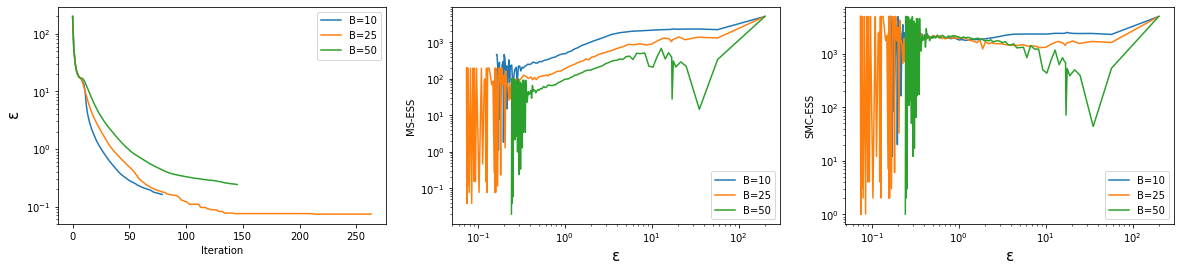

In [175]:
fig, ax = plt.subplots(figsize=(20, 4), ncols=3)
def fESS(ESS, B):
    "Transforms ESS list into np.array and rescaled the values by 1/(B+1)"
    return np.array(ESS) / (B+1)

# Epsilons / Iterations
ax[0].plot(MS10.εs, label="B=10")
ax[0].plot(MS25.εs, label="B=25")
ax[0].plot(MS50.εs, label="B=50")
ax[0].set_ylabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[0].set_xlabel("Iteration")
ax[0].set_yscale('log')
ax[0].legend()
# MS-ESS / epsilons
ax[1].plot(MS10.εs, fESS(MS10.ESS, 10), label="B=10")
ax[1].plot(MS25.εs[:-1], fESS(MS25.ESS, 25), label="B=25")
ax[1].plot(MS50.εs, fESS(MS50.ESS, 50), label="B=50")
ax[1].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[1].set_ylabel("MS-ESS")
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend()
# SMC-ESS / epsilons
ax[2].plot(MS10.εs, MS10.ESS_SMC, label="B=10")
ax[2].plot(MS25.εs[:-1], MS25.ESS_SMC, label="B=25")
ax[2].plot(MS50.εs, MS50.ESS_SMC, label="B=50")
ax[2].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=15)
ax[2].set_ylabel("SMC-ESS")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].legend()
plt.suptitle("")
plt.show()

##### Lets study the histograms?

In [176]:
def plot_histogram(indeces, n):
    fig, ax = plt.subplots(figsize=(20, 4))
    bins = np.arange(start=-0.5, stop=(20+1), step=1)
    _ = ax.hist(indeces[n, :], bins=bins, edgecolor='k', color='lightsalmon')
    ax.set_xticks(np.arange(20+1))
    return plt.show()
resetwarnings()

In [178]:
interact(lambda n: plot_histogram(MS10.K_RESAMPLED[1:, ], n) , n=(0, len(MS10.ϵs) - 2))

interactive(children=(IntSlider(value=39, description='n', max=78), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(n)>

In [179]:
interact(lambda n: plot_histogram(MS25.K_RESAMPLED[1:, ], n) , n=(0, len(MS25.ϵs) - 2))

interactive(children=(IntSlider(value=131, description='n', max=262), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(n)>

In [180]:
interact(lambda n: plot_histogram(MS50.K_RESAMPLED[1:, ], n) , n=(0, len(MS50.ϵs) - 2))

interactive(children=(IntSlider(value=72, description='n', max=144), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>(n)>